In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import polytope
import numpy as np
from interval import interval, imath
from scipy.interpolate import interp1d

In [173]:
# Take a random network
# Simple example, 2 feature in 1 feature out
# The internal layers do not matter for now, except for the activation functions
net = nn.Sequential(
    nn.Linear(in_features=2, out_features=10, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=4, bias=True),
    nn.Sigmoid()
)

input_features = net[0].weight.shape[1]

input_size = net[0].weight.shape[0]

input_features

2

In [174]:
# Select the sampling region for the inputs and sampling interval
samples = 10000

#set the seed for reproducibility
torch.random.manual_seed(100)

# Per feature uniform sampling
feat_1 = torch.distributions.uniform.Uniform(-1,1).sample([samples])
feat_2 = torch.distributions.uniform.Uniform(-1,1).sample([samples])

# Combine the features
feat = torch.stack([feat_1, feat_2],1)


In [175]:
# Evaluate the network in the sampled points
sample_output = net(feat)
poly_points = sample_output.detach().numpy()

poly_points_class_0 = np.reshape(poly_points[:,0], (samples, 1))
poly_points_class_1 = np.reshape(poly_points[:,1], (samples, 1))

In [176]:
# Create the polytope from the points
# this is the reachability set
poly0 = polytope.qhull(poly_points_class_0)
poly1 = polytope.qhull(poly_points_class_1)



(10000, 1)

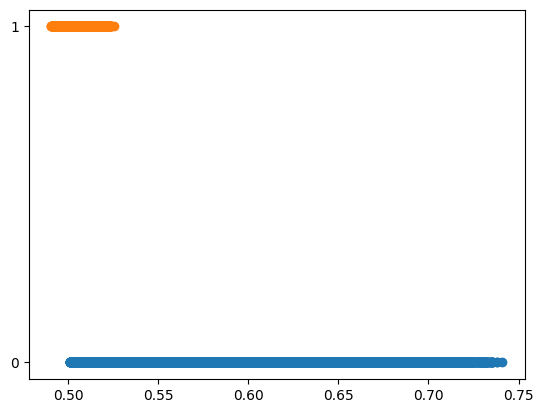

In [177]:
e0 = polytope.extreme(poly0)
e1 = polytope.extreme(poly1)
#tree.plot(color="white")
p0 = np.hstack( (np.zeros((len(poly_points_class_0), 1)), poly_points_class_0))
p1 = np.hstack( (np.ones((len(poly_points_class_1), 1)), poly_points_class_1))

plt.scatter(p0[:,1], p0[:,0])
plt.scatter(p1[:,1], p1[:,0])
plt.yticks([0,1])

poly_points_class_0.shape

In [8]:
# Print the equations for PVS
# A x <= b
A = tree.A
b = tree.b

eq_buff = []
for i,b in enumerate(b):
    str_buff = []
    for j,a in enumerate(A[i]):
        str_buff.append(str(a)+"*x"+str(j))
    eq_buff.append("+".join(str_buff)+ "<=" + str(b))

and_string = " AND ".join(eq_buff)

and_string

NameError: name 'tree' is not defined

In [178]:
import functools
def implements(torch_function):
    """Register a torch function override for ScalarTensor"""
    def decorator(func):
        functools.update_wrapper(func, torch_function)
        HANDLED_FUNCTIONS[torch_function] = func
        return func
    return decorator

HANDLED_FUNCTIONS = {}
class IntervalTensor(object):
    def __init__(self, intervals):
        self._value = from_np(intervals)

    def __repr__(self):
        return "IntervalTensor(value={})".format(self._value)
    
    def data(self):
        return self._value
    
    @classmethod
    def __torch_function__(cls, func, types, args=(), kwargs=None):
        if kwargs is None:
            kwargs = {}
        if func not in HANDLED_FUNCTIONS or not all(
            issubclass(t, (torch.Tensor, IntervalTensor))
            for t in types
        ):
            return NotImplemented
        return HANDLED_FUNCTIONS[func](*args, **kwargs)
    
@implements(torch.nn.functional.linear)
def Linear(input, weight, bias=None):
    result = [interval(0)]*len(weight)
    rint = IntervalTensor(result)
    for h,r in enumerate(weight):
        r_accum = interval(0)
        for i,c in enumerate(r):
            r_accum+=c.item()*input._value[i]
        r_accum+=bias[h].item()
        result[h] = r_accum
    rint._value = result = result;
    return rint
    

@implements(torch.nn.functional.relu)
def ReLU(input, inplace=False):
    ints = input._value
    for i,v in enumerate(ints):
        ints[i] = relu_interval(v)
    return input

@implements(torch.sigmoid)
def Sigmoid(input, inplace=False):
    ints = input._value
    for i,v in enumerate(ints):
        ints[i] = sigmoid_interval(v)
    return input

# Array in the form [[lb0,ub0], [lb1, ub1] ...]
def from_np(np_array): 
    new_arr = []
    for pair in np_array:
        if len(pair) > 2:
            new_arr.append(interval(*pair))
        else:
            new_arr.append(interval(pair))
        
    return new_arr

def sigmoid_interval(intr):
    return 1/(1+imath.exp(-intr))

@interval.function
def relu_interval(c):
    lb = c.inf if c.inf > 0 else 0
    ub = c.sup if c.sup > 0 else 0 
    return [[lb,ub]]

def extract_output_tensor(interval_tensor):
    idata = interval_tensor.data()
    out_data = [0]*len(idata)
    for l_,i_ in enumerate(idata):
        feat_ = np.array(i_[0]).reshape(2,1)
        label_ = (np.ones(2)*l_).reshape(2,1)
        stacked = np.hstack((label_, feat_))
        out_data[l_] = stacked
    return out_data

In [206]:
intervals = np.array([[-1,1],[-1,1]], dtype=object)
i = IntervalTensor(intervals)

o =  net(i)

o

net(torch.tensor([-1.0,-20.0])), o

bounds=extract_output_tensor(o)

bb=np.array(bounds).reshape(8,2)

bb

array([[0.     , 0.48578],
       [0.     , 0.75876],
       [1.     , 0.34723],
       [1.     , 0.69259],
       [2.     , 0.37524],
       [2.     , 0.67848],
       [3.     , 0.28338],
       [3.     , 0.57225]])

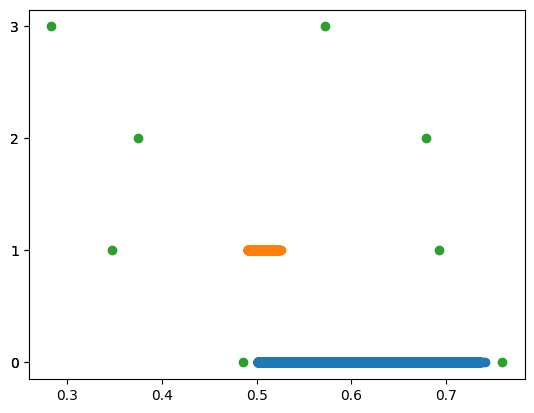

In [211]:
plt.scatter(p0[:,1], p0[:,0]);
plt.scatter(p1[:,1], p1[:,0]);
plt.scatter(bb[:,1], bb[:,0]);
plt.yticks(bb[:,0]);